In [1]:
from resample.bootstrap import resample
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve, roc_curve
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

In [2]:
# original data
X, y = datasets.make_moons(200, noise=0.3, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=1)

# original classifier
clf = RandomForestClassifier(random_state=1)
clf.fit(X_train, y_train);

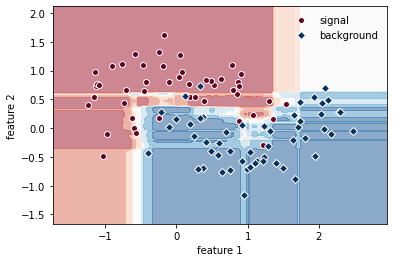

In [3]:
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

cm = plt.cm.RdBu
# Plot the training points
plt.plot(X_test[:, 0][y_test == 0], X_test[:, 1][y_test == 0], "o",
         color=cm(0.0), mec="w", label="signal")
plt.plot(X_test[:, 0][y_test == 1], X_test[:, 1][y_test == 1], "D",
         color=cm(1.0), mec="w", label="background")

# Plot model
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=0.5, zorder=0)
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.legend(frameon=False);

In [4]:
# generate ROC curve with validation set
fpr1, tpr1, thr1 = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])

In [5]:
# generate ROC curve of classifier without separate validation set
w_s = 0
w_b = 0
xrange = (0, 1)
bins = 50
for Xi, yi in resample(X_train, y_train, size=50):
    clf.fit(Xi, yi)
    pi = clf.predict_proba(X)[:, 1]
    w_s += np.histogram(pi[y == 1], range=xrange, bins=bins)[0]
    w_b += np.histogram(pi[y == 0], range=xrange, bins=bins)[0]

tpr2 = 1 - np.cumsum(w_s) / np.sum(w_s)
fpr2 = 1 - np.cumsum(w_b) / np.sum(w_b)

Text(0, 0.5, 'True positive rate')

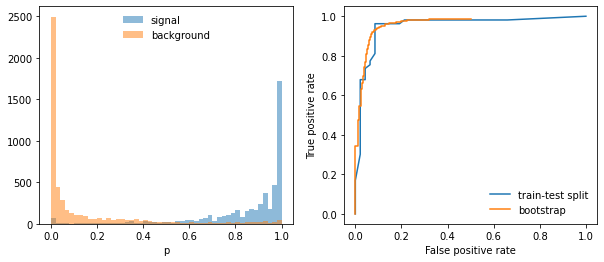

In [6]:
xe = np.linspace(*xrange, bins + 1)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(ax[0])
plt.stairs(w_s, xe, fill=True, alpha=0.5, label="signal")
plt.stairs(w_b, xe, fill=True, alpha=0.5, label="background")
plt.legend(frameon=False, loc="upper center")
plt.xlabel("p");
plt.sca(ax[1])
plt.plot(fpr1, tpr1, label="train-test split")
plt.plot(fpr2, tpr2, drawstyle="steps-post", label="bootstrap")
plt.legend(frameon=False)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")